In [1]:
import flopy as fp
import numpy as np
import geopandas as gp
import matplotlib.pyplot as plt
from flopy.utils.gridgen import Gridgen 
import shapely
from flopy.utils.gridintersect import GridIntersect

flopy is installed in C:\Users\emmal\Anaconda3\lib\site-packages\flopy


In [2]:
model_dir = "working"
model_name="shp_test"
exe_name="../../exe.mf6"

In [3]:
Lx = 50000
Ly = 50000
nlay=1
ncol = nrow = 22
delr = np.ones(ncol)*(Lx/ncol)
delc = np.ones(ncol)*(Ly/nrow)
top=1.
botm=0.
idomain = np.zeros((nrow*ncol))
x0 = 660000
y0 = 6150000


#import shp
R_path="../data/limiteModeleRoussillon_poly.shp"

In [4]:
#create a fake simulation in order to use gridgen

simfake = fp.mf6.MFSimulation(sim_name='theis_mf6', version='mf6', exe_name=exe_name, 
                             sim_ws=model_dir)
gwffake = fp.mf6.ModflowGwf(simfake, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))
dis = fp.mf6.ModflowGwfdis(gwffake, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=botm,xorigin=x0,yorigin=y0,idomain=idomain)

In [5]:
# create the gridgen object
g = Gridgen(dis,model_ws=model_dir,exe_name="../../exe/Gridgen.exe")

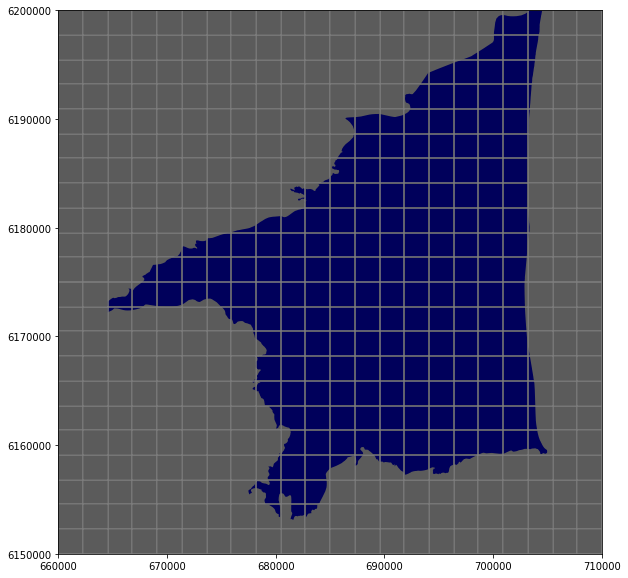

In [6]:
# let's check the grid, the shapefile and inactive cells (all the cells are inactive at this moment)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mm = fp.plot.PlotMapView(model=gwffake)
mm.plot_grid()
fp.plot.plot_shapefile(R_path, ax=ax, facecolor='blue', edgecolor='none',alpha=1)
mm.plot_inactive(alpha=0.4)

In [7]:
R = gp.read_file(R_path) # import shapefile using geopandas --> for the next part

In [8]:
# extract coordinates of the boundary in order to set the limits of the model
domainpoly = []
for x,y in zip(R.geometry[0].boundary.xy[0],R.geometry[0].boundary.xy[1]):
    domainpoly.append((float(x), float(y)))
maximum_area = 1
a=[[domainpoly]] # this line is extremely important because you need to present a 
# list of the type [[[(x,y),...]]] in gridgen and domain poly is [(x,y),...]

In [9]:
# this line can exclude cell outside of the polygon but the resulting grid will not be structured anymore (DISV, DISU)

#g.add_active_domain(a, range(nlay))

In [10]:
g.build() # create the grid (basically here the grid is structured and regular and it changes noting)

In [11]:
poly_intersect = g.intersect(a,"polygon",0)
boundary_intersect = g.intersect(a,"line",0)
idomain[poly_intersect.nodenumber]=1
idomain[boundary_intersect.nodenumber]=1 # choose inactive or active boundaries cells
dis = fp.mf6.ModflowGwfdis(gwffake, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=botm,xorigin=660000,yorigin=6150000,idomain=idomain)

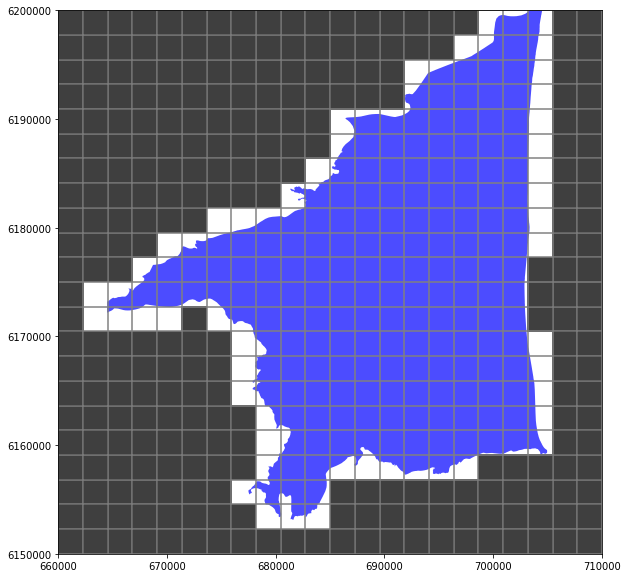

In [12]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mm = fp.plot.PlotMapView(model=gwffake)
mm.plot_grid()
fp.plot.plot_shapefile(R_path, ax=ax, facecolor='blue', edgecolor='none',alpha=0.7)
mm.plot_inactive(alpha=0.5)


### La suite est constituée de tests avec le module fp.discretization de flopy, shapely, etc.

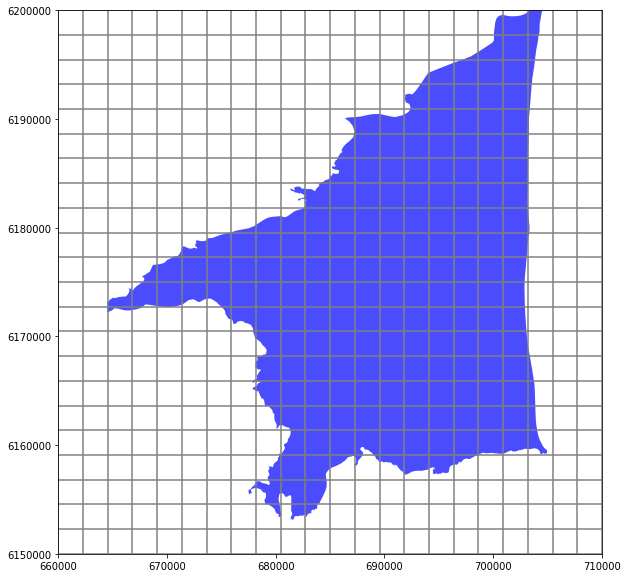

In [13]:
#create a simple grid
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

delc = delc*np.ones(nrow,dtype=np.float)
delr = delr*np.ones(ncol,dtype=np.float)
grid=fp.discretization.StructuredGrid(delc=delc,delr=delr,xoff=x0,yoff=y0)
grid.plot()
fp.plot.plot_shapefile(R_path, ax=ax, facecolor='blue', edgecolor='none',alpha=0.7)

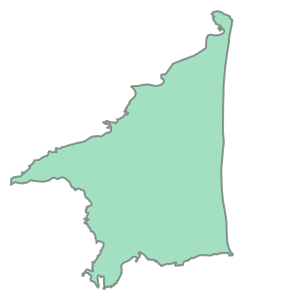

In [14]:
R.geometry[0]

In [15]:
# this block extract cellids that are inside the polygon and put them in lst, also attribute idomain=1
# this method is slower than using gridgen

ix = GridIntersect(grid)
result = ix.intersect_polygon(R.geometry[0])
result2 = result[result.areas>(np.max(result.areas)/3)]

ir=[];ic=[];lst_in=[];
for irow, icol in result2.cellids:
    ir.append(irow)
    ic.append(icol)
    idomain[irow*nrow+icol]=1 # apply idomain inside the polygon
for a in zip(ir,ic):
    lst_in.append(a)

In [16]:
#petit code pour extraire les cellids des cells aux frontieres

def cellidBD(lst_in):   
    lst_bc=[]
    lst_in2=np.array(lst_in)
    for i in range(len(lst_in)):
        xl=lst_in[i][0]
        yl=lst_in[i][1]
        rec = (xl,yl)
        recx1 = (xl+1,yl)
        recx_1= (xl-1,yl)
        recy1 = (xl,yl+1)
        recy_1= (xl,yl-1)
        voisins = [recx1,recx_1,recy1,recy_1];
        for k in voisins:
            mask = (lst_in2==k)[:,0]*(lst_in2==k)[:,1]
            if lst_in2[mask].size == 0:
                lst_bc.append(rec)
                break
    return lst_bc

lst_bc = cellidBD(lst_in)

lsta_bc = np.array(lst_bc)
lst_bc = []
for x,y in lsta_bc:
    a=(0,x,y) # (layer,row,col)
    lst_bc.append(a)

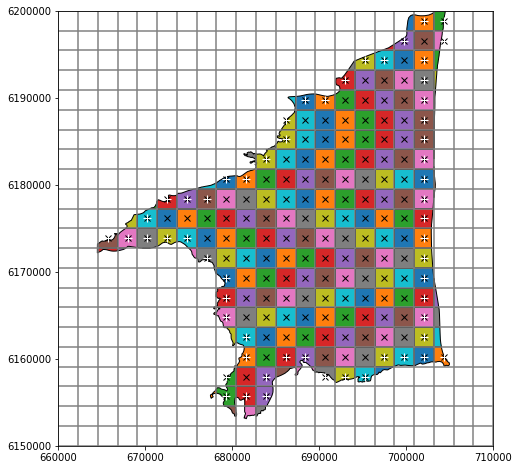

In [17]:
# plot intersections
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
grid.plot(ax=ax)
ix.plot_polygon(result, ax=ax)

for irow, icol in result2.cellids:
    h2, = ax.plot(grid.xcellcenters[0, icol], grid.ycellcenters[irow, 0], 
                  "kx", label="centroids of intersected gridcells")
for ilay,irow,icol in lst_bc:
    h2, = ax.plot(grid.xcellcenters[0, icol], grid.ycellcenters[irow, 0],"w+", markersize=8,
                   label="centroids of intersected gridcells")

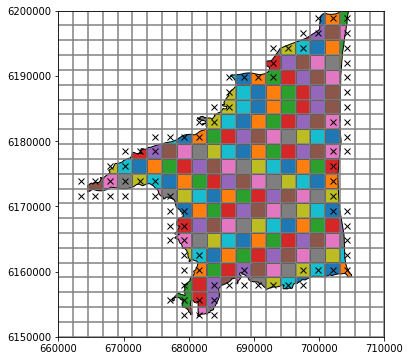

In [18]:
# check only the cells intersect by the boundary of the shp
b_intersect = ix.intersect_linestring(R.geometry[0].boundary)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
grid.plot(ax=ax)
ix.plot_polygon(result, ax=ax)

for irow, icol in b_intersect.cellids:
    h2, = ax.plot(grid.xcellcenters[0, icol], grid.ycellcenters[irow, 0], 
                  "kx", label="centroids of intersected gridcells")
    
ir=[];ic=[];lst_out=[];
for irow, icol in b_intersect.cellids:
    ir.append(irow)
    ic.append(icol)
    idomain[irow*nrow+icol]=0 # cells at the boundary become inactive
for a in zip(ir,ic):
    lst_out.append(a)

In [19]:
# this function can extract cellids intersects by a shp (layer can be specified (in list), default is 0)

def shp2cellids (grid, shp, type = "polygon",layer=[0]):
    
    ix = GridIntersect(grid)
    if type == "polygon":
        result = ix.intersect_polygon(shp.geometry[0])
        result = result[result.areas>(np.max(result.areas)/3)] # only take into account cells that have a least 1/3 intersected by the polygon
        
    if type == "line" :
        result = ix.intersect_linestring(shp.geometry[0].boundary)

    ir=[];ic=[];lst=[];
    for i in range(len(layer)):
        for irow, icol in result.cellids:
            lst.append(((layer[i],irow,icol)))
    return lst